In [2]:
import os
import json
import nibabel as nib
import numpy as np
from tqdm.notebook import tqdm
import cv2
import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm
from keras.optimizers import Adam
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
tf.compat.v1.enable_eager_execution()
import keras
from keras.models import Model
from keras.utils import normalize
from keras.layers import Input, Conv2D, Conv1D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Concatenate
import albumentations as A

In [3]:
"""
Load training data into images and labels lists
 
images list consists of CT scans -  numpy arrays of shape (512, 512, n_slices)
labels list consists of ground truth masks -  numpy arrays of shape (512, 512, n_slices), where:
    0 - background class
    1 - regions of consolidation class
"""
 
path = '/content/drive/MyDrive/data/data' # Replace this line with path to data directory
path_images = os.path.join(path, 'images')
path_labels = os.path.join(path, 'labels')
with open('/content/drive/MyDrive/med_images/training_data.json', 'r') as f:
    dict_training = json.load(f)
 
images = []
labels = []
for entry in tqdm(dict_training):
    image = np.asarray(nib.load(os.path.join(path_images, entry['image'])).get_fdata())
    label = np.asarray(nib.load(os.path.join(path_labels, entry['label'])).get_fdata())
    image = cv2.resize(image, (256, 256))
    label = cv2.resize(label, (256, 256))
    k = image.shape[2]
    for s in range(k):
      m = np.mean(image[:,:,s])
      std = np.std(image[:,:,s])
      image[:,:,s] = (image[:,:,s] - m) / std
    images.append(image)
    labels.append(label)

100%|██████████| 40/40 [00:18<00:00,  2.17it/s]


Разделим данные для обучения и валидации:

In [4]:
partition = {'train': ['study_0301', 'study_0287', 'study_0299', 'study_0283', 'study_0295', 'study_0278', 'study_0259',
                       'study_0289', 'study_0272', 'study_0261', 'study_0270', 'study_0268', 'study_0296', 'study_0281',
                       'study_0286', 'study_0276', 'study_0274', 'study_0284', 'study_0290', 'study_0298',
                       'study_0264', 'study_0262', 'study_0282', 'study_0285', 'study_0271', 'study_0269', 'study_0257',
                       'study_0291', 'study_0266', 'study_0265', 'study_0297', 'study_0273', 'study_0263', 'study_0255',
                       'study_0294', 'study_0288', 'study_0300', 'study_0256'], 
             'testing': ['study_0260', 'study_0303']}

Генератор для данных (с аугментациями), так как данных много и они занимают очень много ОЗУ:

In [14]:
def simple_generator(list_IDs, batch_size):
  j = 0
 
  transform = A.Compose([
    A.Flip(p=0.4),
    A.RandomRotate90(p=0.5)
    ],
    additional_targets = {'image0' : 'image'}
    )   
  X = []
  y = []
  while (1):
    random.shuffle(list_IDs)
    for i, ID in enumerate(list_IDs):
        im = np.asarray(nib.load('/content/drive/MyDrive/data/data/images/' + ID + '.nii').get_fdata())
        lb = np.asarray(nib.load('/content/drive/MyDrive/data/data/labels/' + ID + '_mask.nii').get_fdata())
        im = cv2.resize(im, (256, 256))
        lb = cv2.resize(lb, (256, 256))
        transformed = transform(image=im, image0=lb)
        im = transformed['image']
        lb = transformed['image0']
        lb = np.stack([lb < 0.5, lb > 0.5], axis=3).astype('float64')
        k = im.shape[2]
        for s in range(k):
            imm = im[:,:,s]
            m = np.mean(imm)
            std = np.std(imm)
            imm = (imm - m) / std
            if (j < batch_size):
                X.append(imm)
                y.append(lb[:,:,s,:])
                j += 1
            else:
                yield np.array(X), np.array(y)
                X = []
                y = []
                j = 1
                X.append(imm)
                y.append(lb[:,:,s,:])

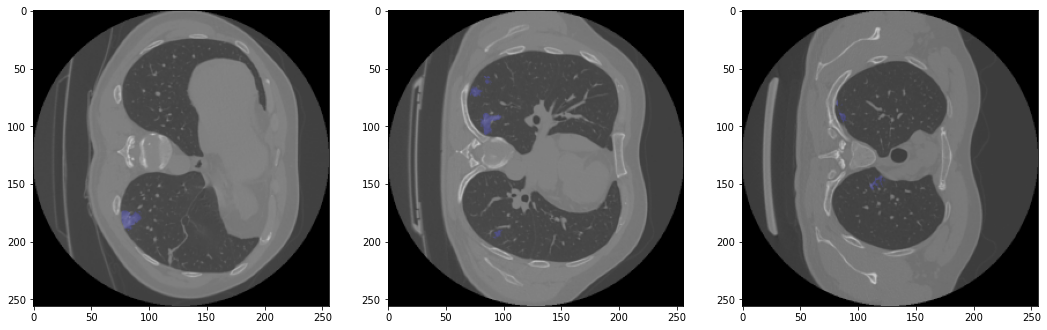

In [15]:
#Visualize some of the slices
from PIL import Image
import matplotlib.pyplot as plt

def blend(image, mask):
    image = image.astype(np.float32)
    min_in = image.min()
    max_in = image.max()
    image = (image - min_in) / (max_in - min_in + 1e-8) * 255
    image = np.dstack((image, image, image)).astype(np.uint8)
    zeros = np.zeros_like(mask)
    mask = np.dstack((zeros, zeros, mask * 255)).astype(np.uint8)
    return Image.blend(
        Image.fromarray(image),
        Image.fromarray(mask),
        alpha=.2
    )

patient_num = 7
slices_num = (10, 20, 30)
slices = []
for idx in slices_num:
    slices.append(blend(
        images[patient_num][..., idx],
        labels[patient_num][..., idx]
    ))

figure = plt.figure(figsize=(18, 18))
for i, image in enumerate(slices):
    ax = figure.add_subplot(1, len(slices), i + 1)
    ax.imshow(slices[i])

Model architecture: (from https://bmcmedimaging.biomedcentral.com/track/pdf/10.1186/s12880-020-00529-5.pdf)

In [16]:
inputs = Input((256, 256, 1))
#Contraction path
c1 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(inputs)
c1 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(c1)

p1 = MaxPooling2D((2, 2))(c1)
c2 = Conv2D(128, (3,3), kernel_initializer='he_normal', padding='same', activation='relu')(p1)
c2 = Conv2D(128, (3,3), kernel_initializer='he_normal', padding='same', activation='relu')(c2)


c3 = Dropout(0.5)(c2)
p2 = MaxPooling2D((2,2))(c3)
c3 = Conv2D(256, (3,3), kernel_initializer='he_normal', padding='same', activation='relu')(p2)
c3 = Conv2D(256, (3,3), kernel_initializer='he_normal', padding='same', activation='relu')(c3)

#Expansive path 
c3 = Dropout(0.5)(c3)
u3 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same', activation='relu')(c3)
    
u3 = concatenate([u3, c2], axis = 3)
c6 = Conv2D(128, (3,3), kernel_initializer='he_normal', padding='same', activation='relu')(u3)
c6 = Conv2D(128, (3,3), kernel_initializer='he_normal', padding='same', activation='relu')(c6)
     
u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same', activation='relu')(c6)
u7 = concatenate([u7, c1], axis=3)

c7 = Conv2D(64, (3,3), kernel_initializer='he_normal', padding='same', activation='relu')(u7)
c7 = Conv2D(64, (3,3), kernel_initializer='he_normal', padding='same', activation='relu')(c7)

outputs = Conv2D(2, (1,1), activation = 'softmax')(c7)

In [17]:
from keras import backend as K
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)
 
 
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [18]:
model = tf.keras.Model(inputs, outputs);
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanSquaredError(), dice_coef])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 256, 256, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_11[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_12[0][0]                  
____________________________________________________________________________________________

In [19]:
model.fit(simple_generator(partition['train'], 8),
                    validation_data=simple_generator(partition['testing'], 3), steps_per_epoch = 6432//8, validation_steps = 172//3, epochs=30)

Epoch 1/30
804/804 [==============================] - 252s 312ms/step - loss: 0.0239 - mean_squared_error: 0.0033 - dice_coef: 0.9940 - val_loss: 0.0168 - val_mean_squared_error: 0.0026 - val_dice_coef: 0.9973
Epoch 2/30
804/804 [==============================] - 255s 318ms/step - loss: 0.0100 - mean_squared_error: 0.0019 - dice_coef: 0.9979 - val_loss: 0.0163 - val_mean_squared_error: 0.0029 - val_dice_coef: 0.9969
Epoch 3/30
804/804 [==============================] - 258s 321ms/step - loss: 0.0090 - mean_squared_error: 0.0019 - dice_coef: 0.9979 - val_loss: 0.0149 - val_mean_squared_error: 0.0024 - val_dice_coef: 0.9974
Epoch 4/30
804/804 [==============================] - 260s 324ms/step - loss: 0.0088 - mean_squared_error: 0.0019 - dice_coef: 0.9978 - val_loss: 0.0123 - val_mean_squared_error: 0.0025 - val_dice_coef: 0.9974
Epoch 5/30
804/804 [==============================] - 257s 320ms/step - loss: 0.0086 - mean_squared_error: 0.0019 - dice_coef: 0.9978 - val_loss: 0.0133 - val_m

In [20]:
model.save_weights('/content/drive/MyDrive/weights.h5')

In [21]:
"""
Load testing data into images and labels lists

images list consists of CT scans -  numpy arrays of shape (512, 512, n_slices)
"""
with open('/content/drive/MyDrive/med_images/testing_data.json', 'r') as f:
    dict_testing = json.load(f)

images_testing = []
for entry in tqdm(dict_testing):
    image = nib.load(os.path.join('/content/drive/MyDrive/data/data/images', entry['image']))
    image = np.array(image.get_fdata())
    image = cv2.resize(image, (256, 256))
    images_testing.append(image)

100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


In [ ]:
model.load_weights('/content/drive/MyDrive/weights.h5')

In [36]:
"""
Write your code here

You need to:
 1. Predict labels for CT scans from images list
 2. Store them in the labels_predicted list in form of numpy arrays of shape (512, 512, n_slices), where:
    0 - background class
    1 - regions of consolidation class
"""
labels_predicted = []
for image in tqdm(images_testing):
  s = image.shape[2]
  Y = np.zeros((256, 256, s))
  for i in range(s):
    X = []
    X.append(image[:,:,i])
    P = model.predict(np.array(X))
    Y[:,:,i] = (np.squeeze(P)[:,:,1] > 0.001).astype('float64')
  labels_predicted.append(Y)

100%|██████████| 10/10 [00:19<00:00,  1.95s/it]
